## SUPER-POINT

Aggregates spectral information from a number of stations surrounding the study site

In [1]:
import xarray as xr
import numpy as np
import os
import wavespectra
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
#%% SUPER-POINT + SUPERPOSITION

path=r'/media/administrador/HD/Dropbox/Guam/spec_guam'
stations=[3304,3305,3302,3301,3300,3303] #Stations to build super point
sectors=[(330,30),(30,90),(90,150),(150,210),(210,270),(270,330)] #Angle covered by each station
deg_sup=30 #Degrees of superposition
st_wind=3304 #Station to take the wind from


In [6]:
## DEFINED FUNCTIONS

def fix_dir(base_dirs):
    'fix csiro direction for wavespectra (from -> to)'
    new_dirs = base_dirs + 180
    new_dirs[np.where(new_dirs>=360)] = new_dirs[np.where(new_dirs>=360)] - 360
    
    return new_dirs

def SuperPoint_Superposition(path,stations,sectors,deg_sup,st_wind):
    
    st=xr.open_dataset(os.path.join(path,'station_' + str(stations[0]) + '.nc'))
    efth_all=np.full([len(st.time),len(st.frequency),len(st.direction),len(stations)],np.nan)
    cont=np.full([len(st.direction)],0)
    del st
    
    for s in range(len(stations)):
        
        print('Station: ' + str(stations[s]))
        
        st=xr.open_dataset(os.path.join(path,'station_' + str(stations[s]) + '.nc'))
        st['direction']=fix_dir(st['direction'])
        #Change directions
        
        if (sectors[s][1]-sectors[s][0])<0:
            d=np.where((st.direction.values>sectors[s][0]-deg_sup) | (st.direction.values<=sectors[s][1]+deg_sup))[0]
        else:
            d=np.where((st.direction.values>sectors[s][0]-deg_sup) & (st.direction.values<=sectors[s][1]+deg_sup))[0]
        
        cont[d] += 1
        efth_all[:,:,d,s]=st.Efth[:,:,d]     
        
        if stations[s]==st_wind:
            wsp=st.u10m.values
            wdir=st.udir.values
            depth=np.full([len(st.time.values)],st.depth)

        
    efth=(np.nansum(efth_all,axis=3)/cont)*(np.pi/180)
    super_point = xr.Dataset({'efth': (['time','freq','dir'],efth),
                               'Wspeed': (['time'],wsp),
                               'Wdir': (['time'],wdir),
                               'Depth': (['time'],depth),
                               
                               }, 
                              coords={'time': st.time.values, 
                                      'dir': st.direction.values, 
                                      'freq':st.frequency.values})
    super_point['time']=super_point['time'].dt.round('H').values

    return super_point, cont
    

In [5]:
do=0
if do:
    sp, cont=SuperPoint_Superposition(path,stations,sectors,deg_sup,st_wind)
    sp.to_netcdf(path=os.path.join(path,'Super_point_superposition_'+ str(deg_sup) +'_.nc'))  
else:
    sp=xr.open_dataset(os.path.join(path,'Super_point_superposition_'+ str(deg_sup) +'_.nc'))  
print(sp)

<xarray.Dataset>
Dimensions:  (dir: 24, freq: 29, time: 365756)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-01T01:00:00 ... 2020-09-01
  * dir      (dir) float32 262.5 247.5 232.5 217.5 ... 322.5 307.5 292.5 277.5
  * freq     (freq) float32 0.035 0.0385 0.042349998 ... 0.45885003 0.50473505
Data variables:
    efth     (time, freq, dir) float64 ...
    Wspeed   (time) float32 ...
    Wdir     (time) float32 ...
    Depth    (time) float32 ...


In [11]:
stations=[3303, 3304,3305,3300,3301,3302]
time=110 #Time step to plot as an example

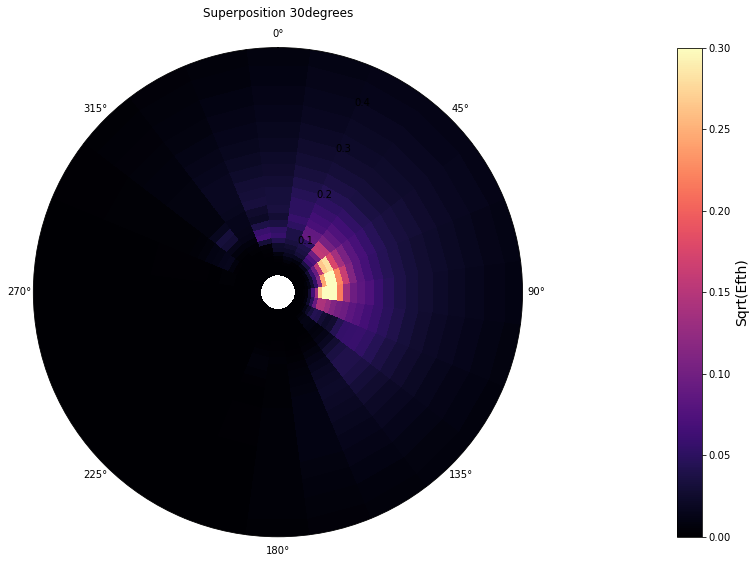

In [16]:
fig = plt.figure(figsize=[18.5,9])
gs2=gridspec.GridSpec(1,1)
ax1=fig.add_subplot(gs2[0],projection='polar')

x=np.deg2rad(sp.dir.values)
x1=np.append(x,x[0])    
z=sp.efth.values[time,:,:]
z1=np.column_stack((z[:,:],z[:,-1]))
p1=ax1.pcolormesh(x1, sp.freq.values,np.sqrt(z1), vmin=0, vmax=0.3)   
p1.set_cmap('magma')    
ax1.set_theta_zero_location('N', offset=0)
ax1.set_theta_direction(-1)
ax1.set_ylim(0,0.49)
ax1.set_title('Superposition ' + str(deg_sup) + 'degrees')
cbar=plt.colorbar(p1, ax=ax1,pad=0.15, format='%.2f')
cbar.set_label('Sqrt(Efth)',fontsize=14) 
  

Station: 3303
Station: 3304
Station: 3305
Station: 3300
Station: 3301
Station: 3302


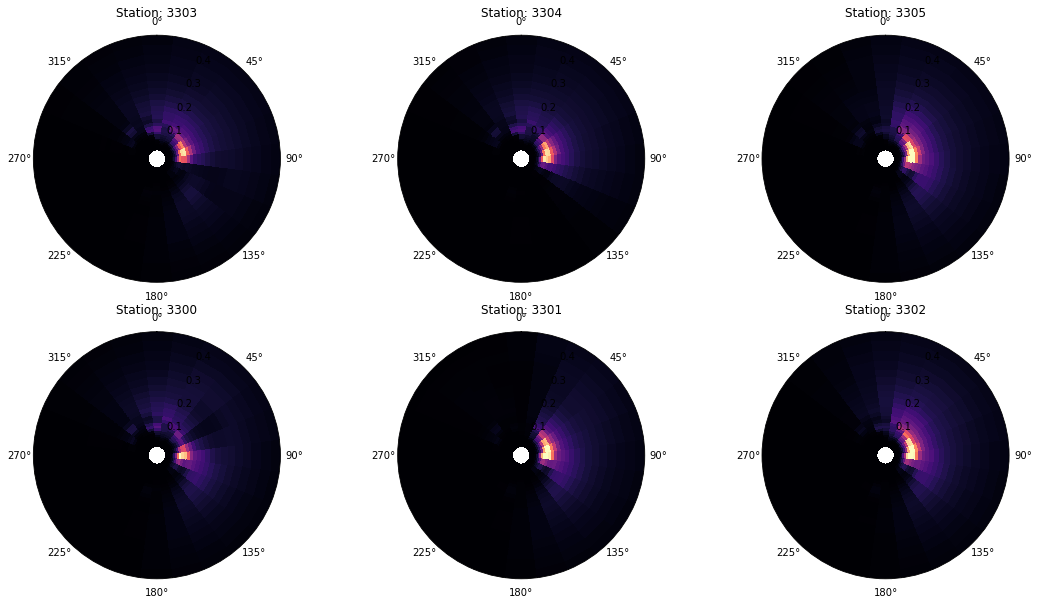

In [7]:


fig = plt.figure(figsize=[18.5,10])
gs1=gridspec.GridSpec(2,3)

for s in range(len(stations)):
        
    print('Station: ' + str(stations[s]))
    st=xr.open_dataset(os.path.join(path,'station_' + str(stations[s]) + '.nc'))
    st['direction']=fix_dir(st['direction'])
    
    ax=fig.add_subplot(gs1[s],projection='polar')
    x=np.deg2rad(sp.dir.values)
    x1=np.append(x,x[0])    
    z=st.Efth.values[time,:,:]
    z1=np.column_stack((z[:,:],z[:,-1]))
    p1=ax.pcolormesh(x1, st.frequency.values,np.sqrt(z1*(np.pi/180)), vmin=0, vmax=0.3)   
    p1.set_cmap('magma')    
    ax.set_theta_zero_location('N', offset=0)
    ax.set_theta_direction(-1)
    ax.set_ylim(0,0.49)
    ax.set_title('Station: ' + str(stations[s]))

Text(0.5, 1.05, 'Mean Spectra')

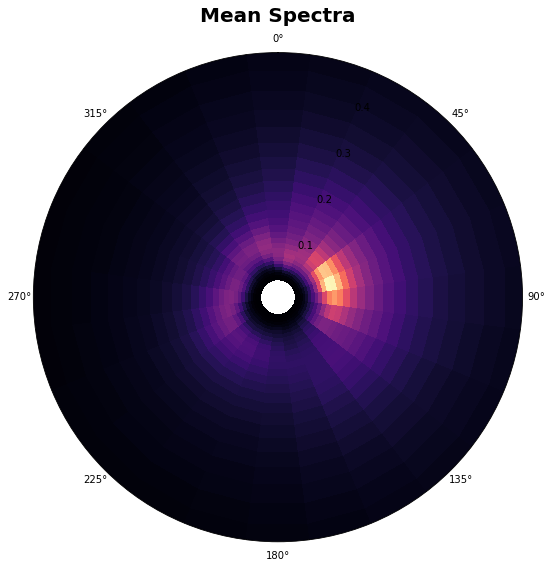

In [20]:
#%% MEAN SPECTRA

fig = plt.figure(figsize=[18.5,9])
gs2=gridspec.GridSpec(1,1)
ax1=fig.add_subplot(gs2[0],projection='polar')

    
x=np.deg2rad(sp.dir.values)
x1=np.append(x,x[0])    
z=np.nanmean(sp.efth.values, axis=0)
z1=np.column_stack((z[:,:],z[:,-1]))
p1=ax1.pcolormesh(x1, sp.freq.values,np.sqrt(z1), vmin=0, vmax=0.2)   
p1.set_cmap('magma')    
ax1.set_theta_zero_location('N', offset=0)
ax1.set_theta_direction(-1)
ax1.set_ylim(0,0.49)
ax1.set_title('Mean Spectra',fontsize=20,fontweight='bold')

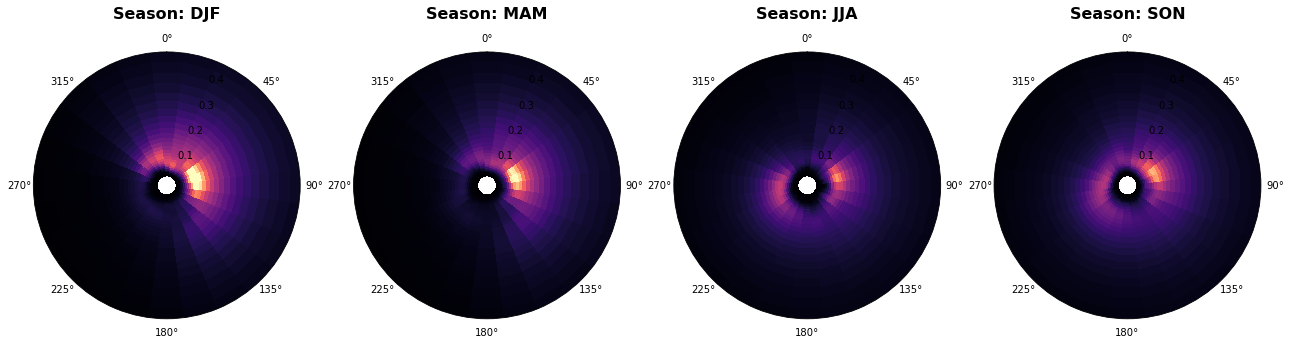

In [24]:
sp_season=sp.groupby('time.season').mean()

#%%

fig = plt.figure(figsize=[22,9])
gs2=gridspec.GridSpec(1,4)

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    
    ax=fig.add_subplot(gs2[i],projection='polar')
    x=np.deg2rad(sp.dir.values)
    x1=np.append(x,x[0])    
    z=sp_season.sel(season=season).efth.values
    z1=np.column_stack((z[:,:],z[:,-1]))
    p1=ax.pcolormesh(x1, sp_season.freq.values,np.sqrt(z1), vmin=0, vmax=0.2)   
    p1.set_cmap('magma')    
    ax.set_theta_zero_location('N', offset=0)
    ax.set_theta_direction(-1)
    ax.set_ylim(0,0.49)
    ax.set_title('Season: ' + season,fontsize=16,fontweight='bold',pad=20)
    